In [1]:
using LinearAlgebra, Random, Distributions, Plots

In [2]:
eps = 10^(-5)

1.0e-5

In [3]:
function cpdeval(U::Vector{Matrix{T}}) where T<:Number
    d = length(U)
    @assert d > 0
    n = [ size(U[k], 1) for k ∈ 1:d ]
    @assert all(n .> 0)
    r = [ size(U[k], 2) for k ∈ 1:d ]
    @assert all(r[2:d] .== r[1])
    r = r[1]
    A = zeros(T, prod(n))
    for α ∈ 1:r
        B = U[1][:,α]
        for k ∈ 2:1:d
            B = kron(U[k][:,α], B)
        end
        A .+= B
    end
    reshape(A, n...)
end

cpdeval (generic function with 1 method)

In [4]:
function matmultensorcpd(::Type{T}, n::Int) where T<:Number
    @assert n ≥ 2
    U = zeros(T, n, n, n, n, n)
    V = zeros(T, n, n, n, n, n)
    W = zeros(T, n, n, n, n, n)
    for i ∈ 1:n, j ∈ 1:n, k ∈ 1:n
        # C_{ij} = \sum_{k=1}^n A_{ik} B_{kj}
        U[i,k,i,j,k] = 1
        V[k,j,i,j,k] = 1
        W[i,j,i,j,k] = 1
    end
    U = reshape(U, n^2, n^3)
    V = reshape(V, n^2, n^3)
    W = reshape(W, n^2, n^3)
    [U,V,W]
end


matmultensorcpd (generic function with 1 method)

In [5]:
function als_cpd(U,V::Vector{Matrix{T}},tol::Int) where T<:Number
    @assert length(U)==length(V)
  
    N = length(U)                                     #A = V_k vec(v_k) of rank R, minimizing u_k or rank r
    A = cpdeval(V)

    R=size(V[1],2)                                    
    r = size(U[1],2)
    cpd_norm = [Float64[] for k ∈ 1:N]
    #println(R,' ',r)
    n = collect(size(U[k], 1) for k ∈ 1:N)
    error = []

    F_forward = [ones(r,R) for l ∈ 1:N]              #F matrix rank rxR
    F_backward = [ones(r,R) for l ∈ 1:N]             #U[l] size n_l*r, V[l] size n_l*R
    
    G_forward = [ones(r,r) for l ∈ 1:N]              #G matrix size rxr
    G_backward = [ones(r,r) for l ∈ 1:N]
    
    for l ∈ 1:N-1
        F=U[l]'*V[l]
        G=U[l]'*U[l]
        F_forward[l+1] = F_forward[l].*F
        G_forward[l+1] = G_forward[l].*G       #building forward and backward matrix F and G
    end
    
    for l in N:-1:2
        F=U[l]'*V[l]
        G=U[l]'*U[l]
        F_backward[l-1] = F_backward[l].*F
        G_backward[l-1] = G_backward[l].*G       
    end
    
    iteration = 0
    while iteration < tol
        iteration += 1
        #println(iteration)
        for k ∈ 1:N
            Identity = I + zeros(n[k],n[k])
          
            V_hat = kron((F_forward[k].*F_backward[k]),Identity)
          
            U_hat = kron((G_forward[k].*G_backward[k]),Identity)
           # println(size(V_hat))
            vec_V = reshape(V[k],n[k]*R)
            b = V_hat * vec_V
  
            vec_U = pinv(U_hat)*b
            
            U[k] = reshape(vec_U,n[k],r)
            
            if k<N
               F=U[k]'*V[k]
               G=U[k]'*U[k]
               F_forward[k+1]=F_forward[k].*F                    #updating forward matrix
               G_forward[k+1]=G_forward[k].*G
            end
        end
        k = N
        F=U[k]'*V[k]
        G=U[k]'*U[k]
        F_backward[k-1]=F_backward[k].*F                          #updating backward at k=n
        G_backward[k-1]=G_backward[k].*G
        
        for k in N-1:-1:2
            Identity = I + zeros(n[k],n[k])
            V_hat = kron((F_forward[k].*F_backward[k]),Identity)     
            U_hat = kron((G_forward[k].*G_backward[k]),Identity)
            
            vec_V = reshape(V[k],n[k]*R)
            b = V_hat * vec_V
            vec_U = U_hat\b
            
            U[k] = reshape(vec_U,n[k],r)
            
            F=U[k]'*V[k]
            G=U[k]'*U[k] 
            F_backward[k-1]=F_backward[k].*F                    #updating backward on the way back 
            G_backward[k-1]=G_backward[k].*G
        end
        A_approx = cpdeval(U)
        for k ∈ 1:N
            push!(cpd_norm[k],norm(U[k]))
        end
        push!(error,norm(A-A_approx))
        #println(error[iteration])
        #if error[iteration]<eps
        #    break
        #end
    end
    return iteration, U, error, cpd_norm
end

als_cpd (generic function with 1 method)

In [6]:
T = Float64
n=2
r=7
V = matmultensorcpd(T,n)
println(size(V[1],2))
N = length(V)
n = collect(size(V[k], 1) for k ∈ 1:N)


nothing;

8


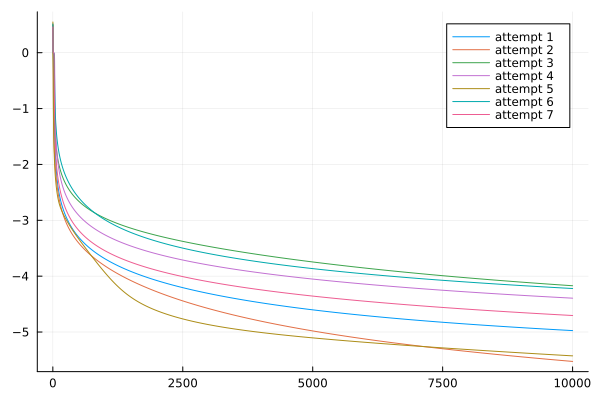

In [7]:
p=plot(; legend=:topright)
error = []
for i in 1:7
    U = [rand(n[k],r) for k ∈ 1:N]
    iter, U_new, err, cpd_norm = als_cpd(U,V,10000)
    plot!(p,log.(err),label="attempt $i ")
    push!(error,err)
end
display(p)

8


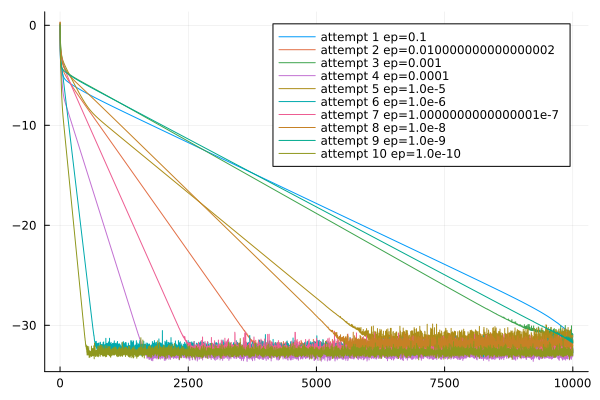

In [27]:
T = Float64
n=2
pp=plot(; legend=:topright)
V = matmultensorcpd(T,n)
println(size(V[1],2))
N = length(V)
n = collect(size(V[k], 1) for k ∈ 1:N)
r=size(V[1],2)
for i = 1:10
    ep = 10^(-Float64(i))
    U = [rand(Uniform(-1,1),n[k],r)+V[k] for k ∈ 1:N]
    iter, U_new, err, cpd_norm = als_cpd(U,V,10000)
    plot!(pp,log.(err),label="attempt $i ep=$ep")
end
display(pp)

In [8]:
n=3
r=23
V1 = matmultensorcpd(T,n)
println(size(V1[1],2))
N = length(V1)
n = collect(size(V1[k], 1) for k ∈ 1:N)

U1 = [rand(n[k],r) for k ∈ 1:N]
nothing;

27


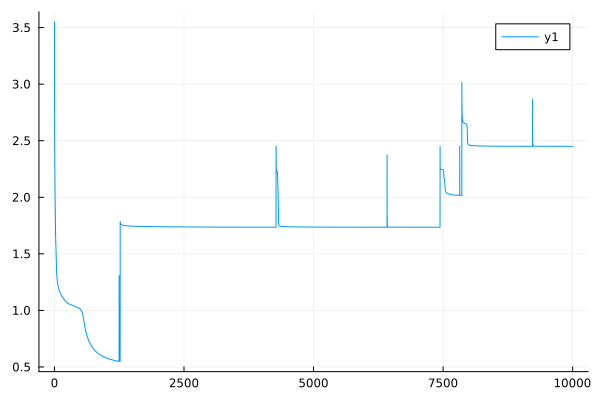

In [9]:
iter1, U_new1, err1, cpd_norm1 = als_cpd(U1,V1,10000)
plot(err1)

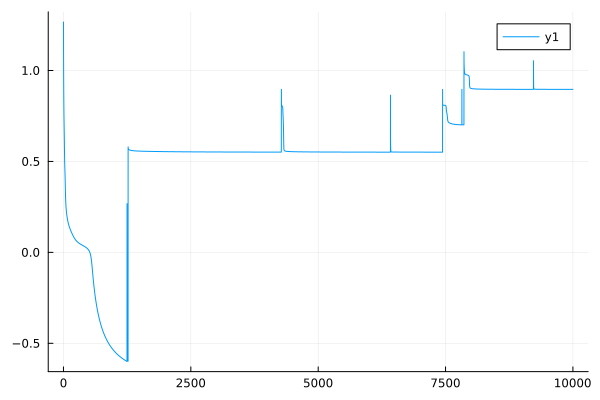

In [10]:
plot(log.(err1))

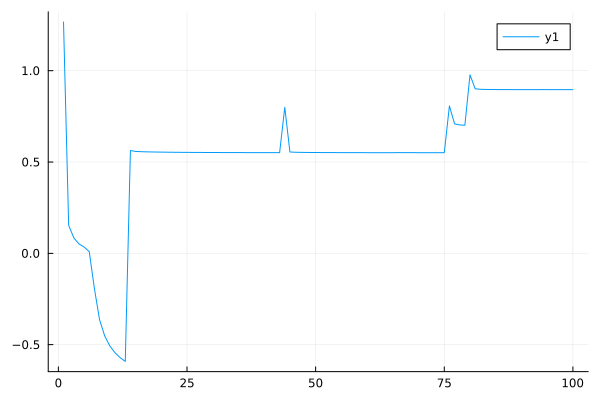

In [11]:
plot(log.(err1[1:100:iter1]))

In [12]:
println(err1[iter1])

2.4505399593224686


In [13]:
U = [0 1 1; 1 0 0]
V = [1 0 1; 0 1 0]
W = [1 1 0; 0 0 1]

T = cpdeval([U,V,W])

2×2×2 Array{Int64, 3}:
[:, :, 1] =
 0  1
 1  0

[:, :, 2] =
 1  0
 0  0

In [14]:
error2 = []
norm_error = []
for i in 1:7
    U_approx = [rand(2,2) for k ∈ 1:3]
    iter,U_new2,err, cpd_norm = als_cpd(U_approx,[U,V,W],1000000)
    push!(error2,err)
    push!(norm_error,cpd_norm[1])
end

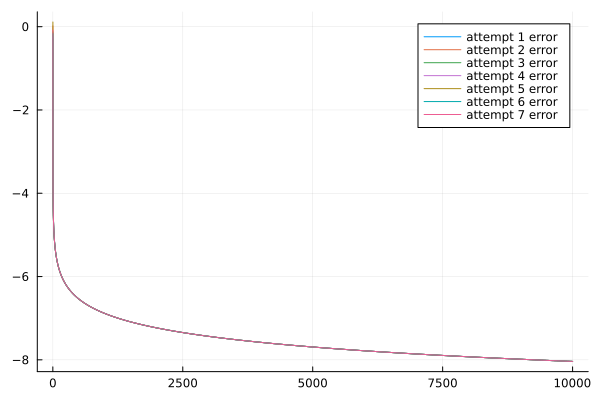

In [20]:
p0 = plot(; legend=:topright)
for i in 1:7
    plot!(p0,log.(error2[i][1:100:1000000]),label="attempt $i error")
end
display(p0)

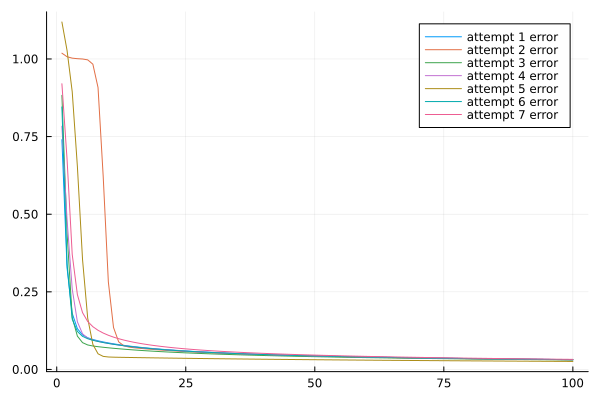

In [21]:
pp = plot(; legend=:topright)
for i in 1:7
    plot!(pp,error2[i][1:100],label="attempt $i error")
end
display(pp)

In [17]:
p1 = plot(; legend=:topright)
for i in 1:7
    plot!(p1,error2[i][1:100:1000000],label="attempt $i error")
    plot!(p1,norm_error[i][1:100:1000000],label="attempt $i cpdnorm")
end
display(p1)